## Reading the TIFF data

In a first step, we read in the TIFF data with `dask-image`.



In [1]:
from dask_image.imread import imread
from pathlib import Path

tiff_image_path = Path(r"C:\Users\kimme\Documents\Temp\osw-data\Human_neuron.tif")
assert tiff_image_path.exists()
tiff_dask = imread(tiff_image_path)

In [2]:
# from pathlib import Path
# from bioio import BioImage, plugin_feasibility_report

# tiff_image_path = Path(r"C:\Users\kimme\Documents\Temp\osw-data\Human_neuron.tif")
# assert tiff_image_path.exists()
# print(plugin_feasibility_report(tiff_image_path))

# tiff_image = BioImage(tiff_image_path)

## Exploring the TIFF image

In the next section, we can have a look at some of the image properties

In [3]:
print(type(tiff_dask))
print(tiff_dask.shape)  # ZYX

<class 'dask.array.core.Array'>
(527, 2614, 2344)


In [4]:
# Defaults to each slice being one chunk (i.e. z=1)
print(tiff_dask.chunksize)

(1, 2614, 2344)


In [5]:
# print(tiff_image.dims)
# print(tiff_image.metadata)

In [6]:
# import matplotlib.pyplot as plt

# def plot_central_slice(image_data, axis=0):
#     idx = image_data.shape[axis] // 2
#     central_slice = image_data.take(indices=idx, axis=axis)
#     plt.imshow(central_slice, cmap='gray')
#     plt.title(f'Central slice along axis {axis}')
#     plt.axis('off')
#     plt.show()

# # the BioImage is 5D and follow TCZYX convention
# # we only want the spatial dimensions
# plot_central_slice(tiff_image.data[0,0], axis=0)
# plot_central_slice(tiff_image.data[0,0], axis=1)

In [7]:
# example of pulling out one slice (Z=100)
tiff_dask[100, :, :]

dask.array<getitem, shape=(2614, 2344), dtype=uint8, chunksize=(2614, 2344), chunktype=numpy.ndarray>

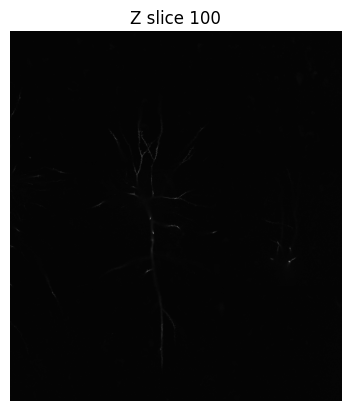

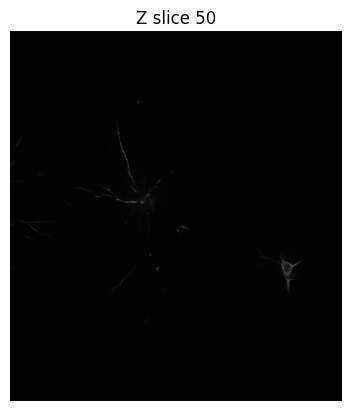

In [8]:
import matplotlib.pyplot as plt

def plot_z_slice(image, z_index):
    plt.imshow(image[z_index, :, :], cmap='gray')
    plt.title(f'Z slice {z_index}')
    plt.axis('off')
    plt.show()

# Plot a few example z slices
plot_z_slice(tiff_dask, 100)
plot_z_slice(tiff_dask, 50)

## Converting to chunked format (zarr)

We have seen that we need to make decisions around storage location, chunk size and compression library and level to write chunked file formats. Let's see whether we can do each of these in Python below!

Next, we specify the chunk size and the compression in an "array specification" (`ArraySpec`)

In [9]:
from pydantic_zarr.v2 import ArraySpec
from numcodecs import Zstd
from numcodecs import Blosc

# As our dask array (and underlying tiff image), has one chunk per z slice. It's most 
# efficient to keep our ome-zarr chunks with z=1 too.
# Chunks of 64x64x64 for example, would require our code to load 64 tiff slices to
# write a single chunk. Then load them again for the next and so on...
array_spec = ArraySpec(
    shape=tiff_dask.shape,
    dtype=tiff_dask.dtype,
    chunks=(1,128,128),
    compressor=Blosc(cname="zstd", clevel=5),
)
print(array_spec)

zarr_version=2 attributes={} shape=(527, 2614, 2344) chunks=(1, 128, 128) dtype='|u1' fill_value=0 order='C' filters=None dimension_separator='/' compressor={'id': 'blosc', 'cname': 'zstd', 'clevel': 5, 'shuffle': 1, 'blocksize': 0}


Now, we specify where we want to story the chunked file - by default, we'll make a folder next to the tiff file.

In [10]:
import zarr

zarr_path = tiff_image_path.parent / "chunked_image"
Path.mkdir(zarr_path, exist_ok=True)
print(f"Created a folder at {zarr_path}")
print(f"Folder contents before creating zarr store {list(zarr_path.iterdir())}")

store = zarr.DirectoryStore(zarr_path)
zarr_array = array_spec.to_zarr(store=store, path="/")
print(f"Folder contents after creating zarr store {list(zarr_path.iterdir())}")

Created a folder at C:\Users\kimme\Documents\Temp\osw-data\chunked_image
Folder contents before creating zarr store []
Folder contents after creating zarr store [WindowsPath('C:/Users/kimme/Documents/Temp/osw-data/chunked_image/.zarray'), WindowsPath('C:/Users/kimme/Documents/Temp/osw-data/chunked_image/.zattrs')]


Note that `zarr_array` doesn't contain any pixel data yet (it's full of zeros) - it now just know where and how it should store data.
So finally, we need to copy the data to the chunked array.

In [ ]:
from timeit import default_timer as timer

start = timer()
tiff_dask.to_zarr(zarr_array)
end = timer()

print(f"Copying took {(end - start)/60} minutes")

In [ ]:
# Let's copy slice by slice (as each slice is small enough to fit in memory)
# Works - but slow!
# for i in range(tiff_dask.shape[0]):
#     print(f"Copying slice Z={i}")
#     zarr_array[i, :, :] = tiff_dask[i, :, :]

In [ ]:
# zarr_array[:] = tiff_image_3d_data[:]

Let's see what's inside the zarr folder now:

In [ ]:
print(f"Folder contents after copying pixel data into zarr {list(zarr_path.iterdir())}")
print(f"There are {len(list(zarr_path.iterdir()))-2} data subfolders")

Can you explain the number of subfolders?

# Converting to pyramidal file format (OME-zarr)

Now we can work on adding lower levels of resolution to the array, and specifying metadata. First, we re-use the same array specification as before, and specity voxel size, units and image name. We also specify that the current array is level 0 of the pyramid.

In [ ]:
from ome_zarr_models.v04 import Image
from ome_zarr_models.v04.axes import Axis

voxel_size = 10
ome_zarr_image = Image.new(
    array_specs = [ArraySpec.from_array(zarr_array)],
    paths = ["level0"],
    axes = [
        Axis(name="z", type="space", unit="um"),
        Axis(name="y", type="space", unit="um"),
        Axis(name="x", type="space", unit="um")
    ],
    global_scale = [voxel_size, voxel_size, voxel_size],
    scales = [[1, 1, 1]],
    translations = [[0, 0, 0]],
    name = "image pyramid",
)
print(ome_zarr_image)

Now we add a new storage location ("store") for the pyramidal file.

In [ ]:
ome_zarr_path = tiff_image_path.parent / "pyramidal_chunked_image"
ome_store = zarr.DirectoryStore(ome_zarr_path)
ome_group = ome_zarr_image.to_zarr(ome_store, path='', overwrite=True)
print(ome_group)

The code to access the array is quite complicated - we need to fill it with values again!

In [ ]:
level0_array = ome_group[ome_zarr_image.attributes.multiscales[0].datasets[0].path]
level0_array[:] = zarr_array[:]

Now let's create more levels by downsampling!

In [ ]:
import math

full_res_spec = ArraySpec.from_array(zarr_array)
print("Original array specification: ", full_res_spec)

downsample_levels = [0, 1, 2]
downsampled_specs = [
    full_res_spec.model_copy(
        update={"shape": tuple(math.ceil(i / 2**d) for i in full_res_spec.shape)
    }) for d in downsample_levels
]
print("Downsampled array specifications: ", downsampled_specs)

In [ ]:
ome_zarr_image = Image.new(
    array_specs = downsampled_specs,
    paths = [f"level{d}" for d in downsample_levels],
    axes = [
        Axis(name="x", type="space", unit="um"),
        Axis(name="y", type="space", unit="um"),
        Axis(name="z", type="space", unit="um")
    ],
    global_scale = [voxel_size, voxel_size, voxel_size],
    scales = [[2**d, 2**d, 2**d] for d in downsample_levels],
    translations = [[0, 0, 0] for d in downsample_levels],
    name = "mouse tibia"
)
print(ome_zarr_image)

ome_group = ome_zarr_image.to_zarr(ome_store, path='', overwrite=True)
print(ome_group)

In [ ]:
for d in downsample_levels:
    level_d_array = ome_group[ome_zarr_image.attributes.multiscales[0].datasets[d].path]
    level_d_array[:] = zarr_array[::2**d, ::2**d, ::2**d]

In [ ]:
import napari

viewer = napari.Viewer()
viewer.open(ome_zarr_path, plugin="napari-ome-zarr")
napari.run()


Some areas for further exploration:
* what parts of the code would you need to change if the data didn't fit in your memory
* how could you change the chunk size?

Or you can move on to the next tutorial, about reading and thresholding OME-zarr data!